In [3]:
# Memory Allocation for using GPU 
import tensorflow as tf 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

from keras.models import load_model
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

1 Physical GPUs, 1 Logical GPUs


## Load Model

In [5]:
BASE_PATH = os.path.abspath(".")
DATA_PATH = os.path.abspath("..\\..\\00_MLDL\\00_BreadBrother\\05_Human_Segmentation")

model = load_model(os.path.join(BASE_PATH, "models\\model.h5"))

## Load Image

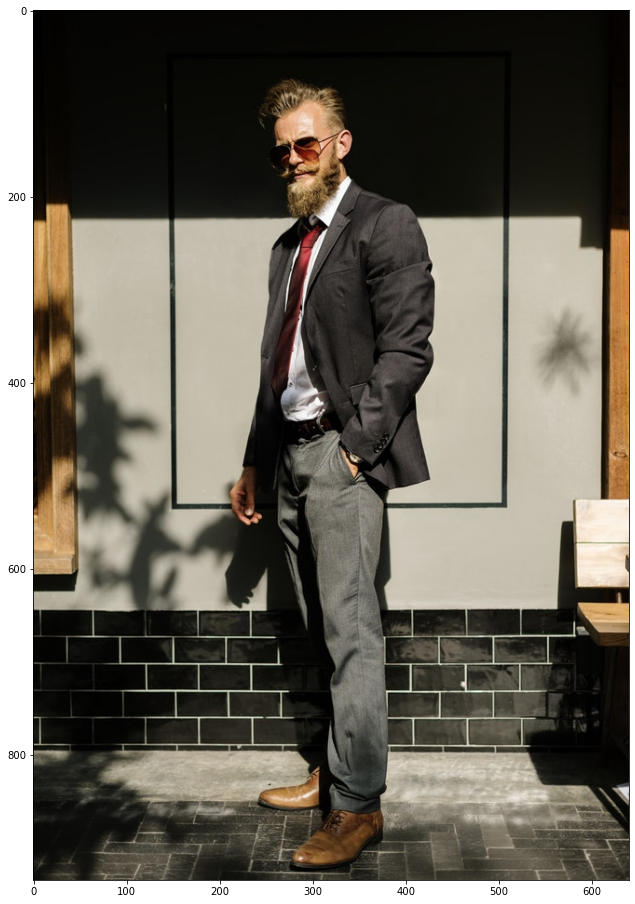

In [26]:
IMG_PATH = os.path.join(DATA_PATH, "human_segmentation-master\\imgs\\04.jpg")

img = cv2.imread(IMG_PATH, cv2.IMREAD_COLOR)
img_ori = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(16,16))
plt.imshow(img_ori)

## Pre-processing

Height: 256, Width: 256


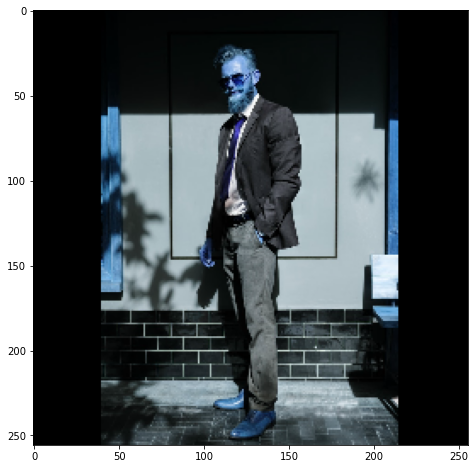

In [30]:
IMG_W, IMG_H = 256, 256

# Source image size = (935, 640, 3)

def preprocess(img):
    im = np.zeros((IMG_W, IMG_H, 3), dtype=np.uint8)

    if img.shape[0] >= img.shape[1]:
        
        # Height을 맞추고 Horizontal padding
        scale = img.shape[0] / IMG_H # Height scale 
        new_width = int(img.shape[1] / scale) # Width calculation by scale
        diff = (IMG_W - new_width) // 2
        img = cv2.resize(img, (new_width, IMG_H)) # (175, 256) (W, H)
        print(f"Height: {img.shape[0]}, Width: {img.shape[1]}") # (Height , Width)

        im[:, diff:diff+new_width, :] = img

    else:
        scale = img.shape[1] / IMG_W
        new_height = int(img.shape[0] / scale)
        diff = (IMG_H - new_height) // 2
        img =cv2.resize(img, (IMG_W, new_height))
        im[diff:diff+new_height, :, :] = img
        

    return im

img = preprocess(img)

plt.figure(figsize=(8,8))
plt.imshow(img)

## Prediction

In [31]:
input_img = img.reshape((1, IMG_W, IMG_H, 3)).astype(np.float32) / 255.

pred = model.predict(input_img)


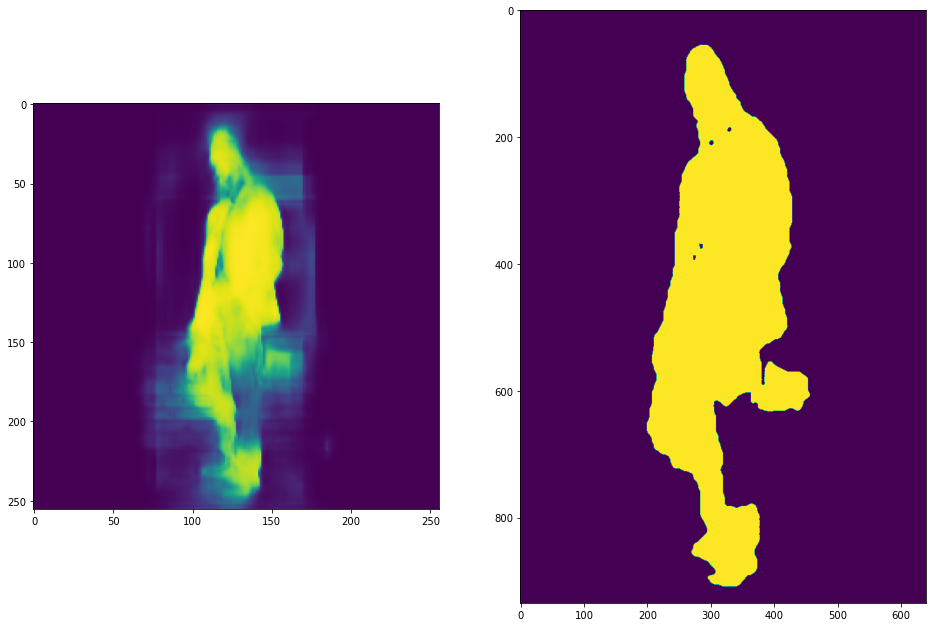

In [35]:
THRESHOLD = 0.5
EROSION = 1

def postprocess(img_ori, pred):
    h, w = img_ori.shape[:2]

    mask_ori = (pred.squeeze()[:, :, 1] > THRESHOLD).astype(np.uint8) # split 1 and 0, Size = (256, 256, 2)
    max_size = max(h, w) # (935, 640) --> 935

    # Maximize Mask Size, (256, 256) --> (935, 935)
    result_mask = cv2.resize(mask_ori, dsize=(max_size, max_size))

    # Crop
    if h >= w:
        diff = (max_size - w) // 2 # 935-640 = 295
        if diff > 0:
            # Cutting width
            result_mask = result_mask[:, diff:-diff]
    else:
        diff = (max_size - h) // 2
        if diff > 0:
            result_mask = result_mask[diff:-diff, :]

    # Mask size (935, 640)
    result_mask = cv2.resize(result_mask, dsize=(w, h))

    result_mask = cv2.GaussianBlur(result_mask, ksize=(9, 9), sigmaX = 5, sigmaY= 5)

    return result_mask


mask = postprocess(img_ori, pred)

plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.imshow(pred[0, :, :, 1])
plt.subplot(1, 2, 2)
plt.imshow(mask)
